In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2 as cv
from tensorflow import keras
from PIL import Image
import math

In [4]:
train_df = pd.read_csv("G:/My Drive/Datasets/plant-pathology-2020-fgvc7/train.csv")

In [5]:
train_df.image_id += str('.jpg')

In [6]:
train_df

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0.jpg,0,0,0,1
1,Train_1.jpg,0,1,0,0
2,Train_2.jpg,1,0,0,0
3,Train_3.jpg,0,0,1,0
4,Train_4.jpg,1,0,0,0
...,...,...,...,...,...
1816,Train_1816.jpg,0,0,0,1
1817,Train_1817.jpg,1,0,0,0
1818,Train_1818.jpg,1,0,0,0
1819,Train_1819.jpg,0,0,1,0


In [7]:
test_df = pd.read_csv("G:/My Drive/Datasets/plant-pathology-2020-fgvc7/test.csv")

In [8]:
test_df.image_id += str('.jpg')

In [9]:
train_df.loc[(train_df.image_id=='Train_1243.jpg')]

,image_id,healthy,multiple_diseases,rust,scab
1243,Train_1243.jpg,0,0,0,1


In [10]:
test_df

,image_id
0,Test_0.jpg
1,Test_1.jpg
2,Test_2.jpg
3,Test_3.jpg
4,Test_4.jpg
...,...
1816,Test_1816.jpg
1817,Test_1817.jpg
1818,Test_1818.jpg
1819,Test_1819.jpg


In [11]:
train_x = []
path = "G:/My Drive/Datasets/plant-pathology-2020-fgvc7/images/"
for image in train_df.image_id:
    img_path = os.path.join(path,str(image))
    train_x.append(img_path)

In [12]:
print("total train images:",len(train_x))

total train images: 1821


(1365, 2048, 3)


Text(0.5, 1.0, 'scab')

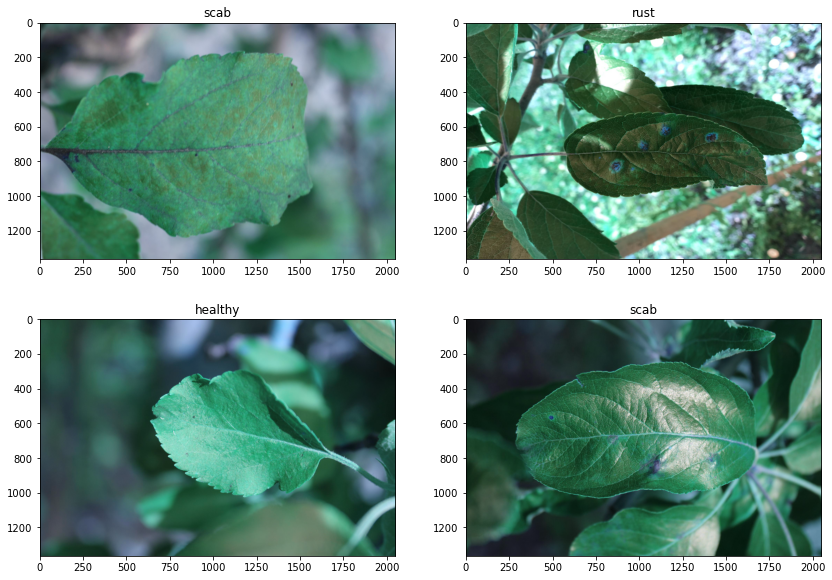

In [13]:
i=1243
print(cv.imread(train_x[i]).shape)
cols = ['healthy','multiple_diseases','rust','scab']
train_labels = np.float32(train_df.loc[:,'healthy':'scab'].values)
fig, arr = plt.subplots(2,2,figsize = (14,10))
arr[0][0].imshow(cv.imread(train_x[i]))
arr[0][0].set_title(cols[tf.math.argmax(train_labels[i])])
arr[0][1].imshow(cv.imread(train_x[i+1]))
arr[0][1].set_title(cols[tf.math.argmax(train_labels[i+1])])
arr[1][0].imshow(cv.imread(train_x[i+2]))
arr[1][0].set_title(cols[tf.math.argmax(train_labels[i+2])])
arr[1][1].imshow(cv.imread(train_x[i+3]))
arr[1][1].set_title(cols[tf.math.argmax(train_labels[i+3])])

In [14]:
train_labels0 = tf.expand_dims(tf.argmax(train_labels.T,axis=0), axis = 1)

In [15]:
print(train_labels0)

tf.Tensor(
[[3]
 [1]
 [0]
 ...
 [0]
 [2]
 [3]], shape=(1821, 1), dtype=int64)


In [16]:
train_x0 = tf.constant(train_x)
train_labels0 = tf.constant(train_labels0)

In [17]:
list_ds0 = tf.data.Dataset.from_tensor_slices((train_x0,train_labels0))

In [18]:
for i,j in list_ds0.take(1):
    print(i,j)

tf.Tensor(b'G:/My Drive/Datasets/plant-pathology-2020-fgvc7/images/Train_0.jpg', shape=(), dtype=string) tf.Tensor([3], shape=(1,), dtype=int64)


In [19]:
val_size = int(0.20*len(train_x))
print(val_size)
train_ds0 = list_ds0.skip(val_size)
val_ds0 = list_ds0.take(val_size)

364


In [20]:
example_path = ""
for path in train_ds0.take(1):
    print(path)
    example_path = path

(<tf.Tensor: shape=(), dtype=string, numpy=b'G:/My Drive/Datasets/plant-pathology-2020-fgvc7/images/Train_364.jpg'>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3], dtype=int64)>)


***PreProcessing***

In [21]:
def distance(point1,point2):
    return math.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def butterworthLP(D0, n, imgShape=(224,224)):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = 1/(1+(distance((y,x),center)/D0)**(2*n))
    return base

def butterworthHP(D0, n, imgShape=(224,224)):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = 1-1/(1+(distance((y,x),center)/D0)**(2*n))
    return base

In [22]:
def process_path0(file_path,label):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    img = preprocess0(img)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    img = tf.image.resize(img, (224,224))
    print("...",end='\n')
    return img, label

In [23]:
def preprocess0(img):
    img = tf.image.rgb_to_grayscale(img)
    img = tf.cast(img, tf.complex64)
    
    original = tf.signal.fft2d(img[:,:,0])
    center = tf.signal.fftshift(original)
    
    LowPassCenter = center * butterworthLP(D0=40,n=10)
    LowPass = tf.signal.ifftshift(LowPassCenter)
    inverse_LowPass = tf.signal.ifft2d(LowPass)
    
    HighPassCenter = center * butterworthHP(D0=60,n=10)
    HighPass = tf.signal.ifftshift(HighPassCenter)
    inverse_HighPass = tf.signal.ifft2d(HighPass)

    final_image = tf.stack(((inverse_LowPass),(inverse_HighPass)), axis=2)
    
    final_image_tensor = tf.cast(final_image, tf.uint8)
    
    return final_image_tensor

In [24]:
image_ds0 = train_ds0.map(process_path0)
image_val_ds0 = val_ds0.map(process_path0)

...
...


input_size (224, 224, 2)
label  tf.Tensor([3], shape=(1,), dtype=int64)
input_size (224, 224, 2)
label  tf.Tensor([0], shape=(1,), dtype=int64)
input_size (224, 224, 2)
label  tf.Tensor([0], shape=(1,), dtype=int64)
input_size (224, 224, 2)
label  tf.Tensor([0], shape=(1,), dtype=int64)
input_size (224, 224, 2)
label  tf.Tensor([2], shape=(1,), dtype=int64)
input_size (224, 224, 2)
label  tf.Tensor([2], shape=(1,), dtype=int64)


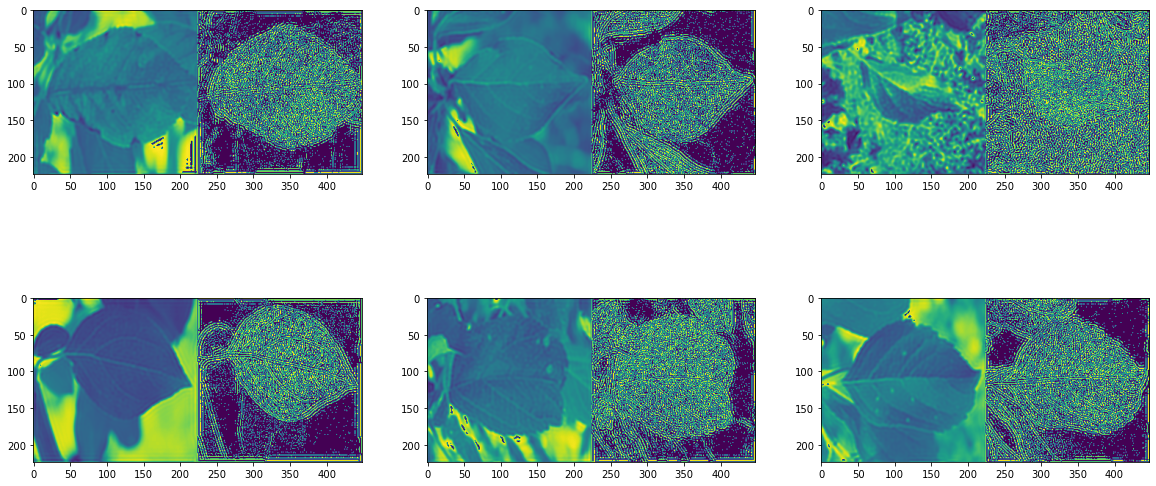

In [25]:
plt.figure(figsize = (20,15))
x=1
for i,j in image_ds0.take(6):
    print('input_size',i.numpy().shape)
    print('label ',j)
    plt.subplot(3,3,x)
    plt.imshow(np.concatenate((i[:,:,0],i[:,:,1]),axis=1))
    x+=1

input_size (224, 224, 2)
label  tf.Tensor([3], shape=(1,), dtype=int64)
input_size (224, 224, 2)
label  tf.Tensor([1], shape=(1,), dtype=int64)
input_size (224, 224, 2)
label  tf.Tensor([0], shape=(1,), dtype=int64)
input_size (224, 224, 2)
label  tf.Tensor([2], shape=(1,), dtype=int64)
input_size (224, 224, 2)
label  tf.Tensor([0], shape=(1,), dtype=int64)
input_size (224, 224, 2)
label  tf.Tensor([0], shape=(1,), dtype=int64)


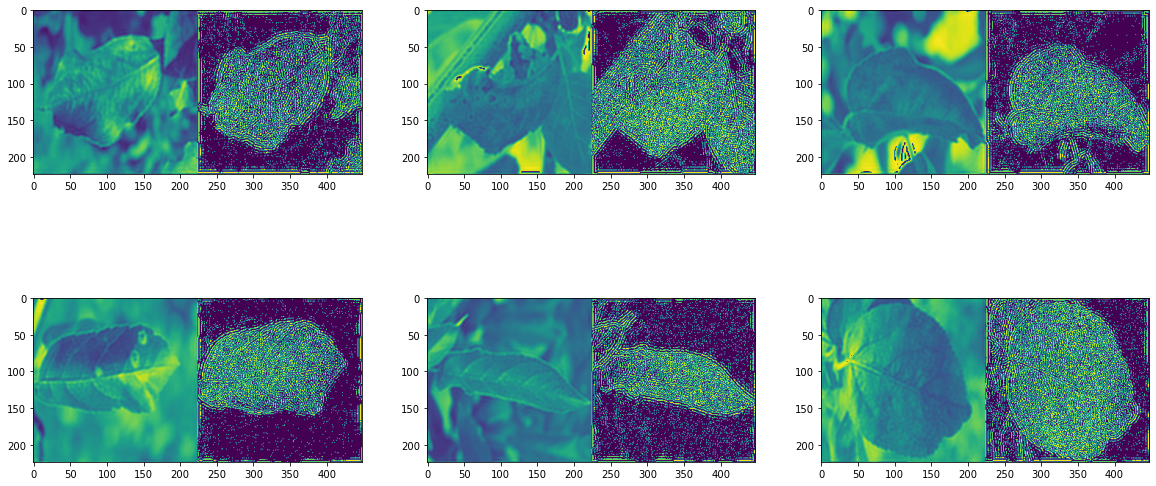

In [26]:
plt.figure(figsize = (20,15))
x=1
for i,j in image_val_ds0.take(6):
    print('input_size',i.numpy().shape)
    print('label ',j)
    plt.subplot(3,3,x)
    plt.imshow(np.concatenate((i[:,:,0],i[:,:,1]),axis=1))
    x+=1

In [27]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=500)
    ds = ds.batch(16)
    return ds

image_ds_r = configure_for_performance(image_ds0)
image_val_ds_r = configure_for_performance(image_val_ds0)

In [28]:
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False,
                                                           input_shape=(224,224,3),
                                                           weights = 'imagenet')

In [29]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [30]:
len(base_model.layers)

311

In [31]:
def f_model(input_shape):
    print(input_shape)
    inputs = tf.keras.layers.Input(shape=input_shape)
    split1 = tf.keras.layers.Lambda(lambda x: x[:,:,:,0:1])(inputs)
    split2 = tf.keras.layers.Lambda(lambda x: x[:,:,:,1:2])(inputs)
    split1 = tf.keras.layers.Conv2D(filters=3, kernel_size = 1,padding = 'same')(split1)
    split2 = tf.keras.layers.Conv2D(filters=3, kernel_size = 1,padding = 'same')(split2)
    base_model = base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False,
                                                           input_shape=(224,224,3),
                                                           weights = 'imagenet')
    base_model.trainable = True
    fine_tune = 280
    for layer in base_model.layers[:fine_tune]:
        layer.trainable = False
    split1 = base_model(split1, training = False)
    split1 = tf.keras.layers.Flatten()(split1)
    split1 = tf.keras.layers.Dense(256,activation = tf.keras.activations.relu)(split1)
    #split1 = tf.keras.layers.Dense(1024,activation = tf.keras.activations.relu, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=0))(split1)
    split1 = tf.keras.layers.Dense(128,activation = tf.keras.activations.relu)(split1)
    
    split2 = base_model(split2, training = False)
    split2 = tf.keras.layers.Flatten()(split2)
    split2 = tf.keras.layers.Dense(256,activation = tf.keras.activations.relu)(split2)
    #split2 = tf.keras.layers.Dense(1024,activation = tf.keras.activations.relu, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=0))(split2)
    split2 = tf.keras.layers.Dense(128,activation = tf.keras.activations.relu)(split2)
    
    merge = tf.keras.layers.Concatenate()([split1,split2])
    
    outputs = tf.keras.layers.Dense(4,activation = tf.keras.activations.softmax)(merge)
    #outputs = tf.keras.layers.Softmax()(merge)
    
    model = tf.keras.models.Model(inputs = inputs, outputs = outputs)
    
    return model

In [32]:
input_shape = (224,224,2)
finalModel = f_model(input_shape)

(224, 224, 2)


In [33]:
for layer in finalModel.layers:
    print(layer)

In [34]:
finalModel.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [35]:
tf.keras.utils.plot_model(finalModel)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [36]:
finalModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 2  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 224, 224, 1)  0           ['input_2[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 224, 224, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 224, 224, 3)  6           ['lambda[0][0]']             

In [178]:
history = finalModel.fit(image_ds_r,
                    validation_data=image_val_ds_r,
                    epochs=60)

Epoch 1/60
103/103 [==============================] - 37s 292ms/step - loss: 1.7577 - accuracy: 0.5387 - val_loss: 0.8158 - val_accuracy: 0.7143
Epoch 2/60
103/103 [==============================] - 28s 274ms/step - loss: 0.7007 - accuracy: 0.7358 - val_loss: 0.8085 - val_accuracy: 0.7143
Epoch 3/60
103/103 [==============================] - 28s 274ms/step - loss: 0.4814 - accuracy: 0.8286 - val_loss: 1.1063 - val_accuracy: 0.6868
Epoch 4/60
103/103 [==============================] - 28s 274ms/step - loss: 0.2932 - accuracy: 0.8932 - val_loss: 1.2293 - val_accuracy: 0.6593
Epoch 5/60
103/103 [==============================] - 28s 277ms/step - loss: 0.1583 - accuracy: 0.9420 - val_loss: 1.6155 - val_accuracy: 0.6868
Epoch 6/60
103/103 [==============================] - 28s 276ms/step - loss: 0.0938 - accuracy: 0.9671 - val_loss: 1.5768 - val_accuracy: 0.7308
Epoch 7/60
103/103 [==============================] - 28s 275ms/step - loss: 0.0647 - accuracy: 0.9774 - val_loss: 1.7360 - val_ac

In [37]:
finalModel = tf.keras.models.load_model("G:\My Drive\Datasets\plant-pathology-2020-fgvc7\PlantPatholoy.hdf5")

In [38]:
preds = finalModel.predict(image_val_ds_r)

In [39]:
labels = tf.argmax(preds,axis=-1)
labels

<tf.Tensor: shape=(364,), dtype=int64, numpy=
array([2, 0, 0, 2, 2, 0, 0, 2, 3, 3, 2, 3, 3, 3, 2, 2, 0, 3, 3, 2, 0, 3,
       0, 0, 2, 0, 2, 0, 3, 0, 1, 2, 2, 0, 2, 0, 2, 0, 2, 3, 2, 2, 2, 3,
       1, 2, 3, 0, 0, 3, 2, 3, 2, 0, 2, 2, 0, 3, 2, 2, 3, 0, 2, 2, 0, 3,
       0, 0, 2, 3, 0, 0, 3, 0, 2, 3, 0, 3, 3, 3, 3, 2, 3, 2, 2, 0, 3, 2,
       0, 0, 2, 2, 2, 3, 3, 3, 3, 2, 2, 0, 2, 3, 3, 3, 2, 2, 3, 0, 2, 0,
       0, 0, 0, 3, 2, 2, 0, 0, 0, 2, 0, 0, 3, 3, 3, 3, 3, 3, 3, 2, 1, 2,
       0, 3, 0, 3, 2, 0, 3, 3, 3, 3, 3, 2, 2, 0, 3, 2, 3, 2, 0, 0, 3, 0,
       2, 2, 0, 2, 3, 2, 3, 2, 3, 2, 2, 1, 2, 2, 0, 3, 2, 3, 3, 2, 3, 3,
       3, 2, 2, 0, 0, 3, 3, 0, 2, 3, 2, 0, 0, 2, 2, 2, 2, 0, 3, 0, 2, 3,
       2, 3, 0, 3, 2, 0, 0, 3, 3, 2, 2, 2, 0, 3, 3, 0, 2, 0, 3, 3, 0, 3,
       2, 1, 3, 3, 3, 2, 2, 2, 3, 2, 2, 0, 3, 0, 0, 2, 0, 3, 1, 3, 3, 3,
       3, 3, 3, 2, 2, 3, 3, 2, 0, 2, 0, 3, 0, 2, 0, 3, 3, 0, 3, 3, 3, 2,
       2, 3, 2, 0, 2, 3, 0, 0, 2, 2, 2, 1, 3, 0, 3, 3, 3, 0, 0, 3, 3, 0,
     

In [53]:
test = []
path = "G:/My Drive/Datasets/plant-pathology-2020-fgvc7/images/"
for image in test_df.image_id:
    img_path = os.path.join(path,str(image))
    test.append(img_path)

In [54]:
test = tf.constant(test)
print(test)

tf.Tensor(
[b'G:/My Drive/Datasets/plant-pathology-2020-fgvc7/images/Test_0.jpg'
 b'G:/My Drive/Datasets/plant-pathology-2020-fgvc7/images/Test_1.jpg'
 b'G:/My Drive/Datasets/plant-pathology-2020-fgvc7/images/Test_2.jpg' ...
 b'G:/My Drive/Datasets/plant-pathology-2020-fgvc7/images/Test_1818.jpg'
 b'G:/My Drive/Datasets/plant-pathology-2020-fgvc7/images/Test_1819.jpg'
 b'G:/My Drive/Datasets/plant-pathology-2020-fgvc7/images/Test_1820.jpg'], shape=(1821,), dtype=string)


In [55]:
test_list = tf.data.Dataset.list_files(test,shuffle=False)
for i in test_list.take(2):
    print(i)

tf.Tensor(b'G:\\My Drive\\Datasets\\plant-pathology-2020-fgvc7\\images\\Test_0.jpg', shape=(), dtype=string)
tf.Tensor(b'G:\\My Drive\\Datasets\\plant-pathology-2020-fgvc7\\images\\Test_1.jpg', shape=(), dtype=string)


In [56]:
def process_path_test(file_path):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    img = preprocess0(img)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    img = tf.image.resize(img, (224,224))
    print("...",end='\n')
    return img

In [57]:
test_ds = test_list.map(process_path_test)

...


In [59]:
test_ds_r = test_ds.cache()
test_ds_r = test_ds.batch(16)

In [60]:
probs = finalModel.predict(test_ds_r,verbose='auto')

In [64]:
SUB_PATH = "G:\My Drive\Datasets\plant-pathology-2020-fgvc7\sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
sub.loc[:, 'healthy':] = probs
sub.to_csv('G:\My Drive\Datasets\plant-pathology-2020-fgvc7\submission.csv', index=False)
sub.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.066136,0.000371,0.004942,9.285510e-01
1,Test_1,0.073453,0.000949,0.924507,1.090780e-03
2,Test_2,0.973560,0.000008,0.026431,5.496331e-07
3,Test_3,0.817016,0.000903,0.151983,3.009783e-02
4,Test_4,0.135952,0.051781,0.789288,2.297923e-02
